In [1]:
import os
import requests
import gzip
import shutil
from typing import Optional, Union, Tuple, List
from dataclasses import dataclass, field

import causallift
from causallift import CausalLift

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

causallift.__version__
pd.options.display.max_rows = 8
seed = 42

/opt/conda/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
def prepare_data(data: str, **kwargs):

    if data == 'simulated_observational_data':
        """
        # Generate simulated data
        # "Sleeping dogs" (a.k.a. "do-not-disturb"; people who will "buy" if not 
        treated but will not "buy" if treated) can be simulated by negative values 
        in tau parameter.
        # Observational data which includes confounding can be simulated by 
        non-zero values in propensity_coef parameter.  
        # A/B Test (RCT) with a 50:50 split can be simulated by all-zeros values 
        in propensity_coef parameter (default).
        # The first element in each list parameter specifies the intercept.
        """
        from causallift import generate_data

        np.random.seed(seed)

        df = generate_data(
            N=20000, 
            n_features=3, 
            beta=[0, -2, 3, -5], # Effect of [intercept and features] on outcome 
            error_std=0.1, 
            tau=[1, -5, -5, 10], # Effect of [intercept and features] on treated outcome
            tau_std=0.1, 
            discrete_outcome=True, 
            seed=seed, 
            feature_effect=0, # Effect of beta on treated outcome
            propensity_coef=[0, -1, 1, -1], # Effect of [intercept and features] on propensity log-odds for treatment
            index_name='index',
        )
        
    elif data == 'lalonde':
        r""" 
            Lalonde dataset was used to evaluate propensity score in the paper:
            Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental 
            Studies: Reevaluating the Evaluation of Training Programs. Journal of 
            the American Statistical Association, 94(448), 1053-1062. 
            doi:10.2307/2669919

            Lalonde dataset is now included in R package named "Matching."
            http://sekhon.berkeley.edu/matching/lalonde.html
        """
        def get_lalonde():
            r""" Load datasets, concatenate, and create features to get data frame 
            similar to 'lalonde' that comes with "Matching.")
            """
            cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
            control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep=r'\s+', header = None, names = cols)
            treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep=r'\s+', header = None, names = cols)
            lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
            lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
            lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
            return lalonde_df
        lalonde_df = get_lalonde()
        
        """ Prepare the input Data Frame. """
        df = lalonde_df.copy()
        df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
        df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
        
        # categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
        df.loc[:,'age'] = df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
        df = pd.get_dummies(df, columns=['age'], drop_first=True) 
        
        cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
                'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
        df = df[cols]

    elif data == 'criteo':
        save_dir = "./raw_data"
        os.makedirs(save_dir, exist_ok=True)

        criteo_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
        zip_file_name = "raw_data/criteo-research-uplift-v2.1.csv.gz"
        unzip_file_name = "raw_data/criteo-research-uplift-v2.1.csv"
        
        if os.path.isfile(unzip_file_name):
            print("The downloaded file already exists!")
        
        else:
            print("Try to download the raw data from the server...")
            response = requests.get(criteo_url, stream=True)
            total_size_in_bytes = int(response.headers.get("content-length", 0))
            block_size = 1024
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(zip_file_name, "wb") as f:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    f.write(data)
            progress_bar.close()
            print("Finished downloading!!!")
            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("Error, something went wrong!")
                return

            print("Try to unzip the downloaded file")
            with gzip.open(zip_file_name, "rb") as f_in:
                with open (unzip_file_name, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            os.remove(zip_file_name)
            print("Zip file removed from disk")

        print("Import the csv file into pd.DataFrame")
        df = pd.read_csv(unzip_file_name)
    
    else:
        raise ValueError("No corresponding data found")

    return df

In [3]:
df = prepare_data("simulated_observational_data")

In [4]:
np.sum(df["Treatment"] == 1)/len(df)
# 15% is treated

0.3859

In [5]:
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_df), len(eval_df))

16000 4000


In [6]:
train_df.head()

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
index,,,,,
5894,0.705646,0.118903,0.591185,1.0,0.0
3728,0.671304,0.990192,0.090662,0.0,1.0
8958,0.048870,0.596951,0.643174,0.0,0.0
7671,0.790777,0.159311,0.252047,0.0,0.0
5999,0.725692,0.692031,0.821540,1.0,0.0


In [7]:
corr = train_df.corr()
corr

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
Feature_0,1.000000,-0.005264,-0.003518,-0.133840,-0.415703
Feature_1,-0.005264,1.000000,0.000265,0.123293,0.103306
Feature_2,-0.003518,0.000265,1.000000,-0.139524,-0.042754
Treatment,-0.133840,0.123293,-0.139524,1.000000,0.322685
Outcome,-0.415703,0.103306,-0.042754,0.322685,1.000000


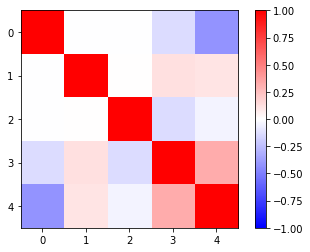

In [8]:
plt.imshow(corr, cmap="bwr")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

In [9]:
pd.crosstab(train_df["Treatment"], train_df["Outcome"])/len(train_df)

Outcome,0.0,1.0
Treatment,,
0.0,0.553188,0.062875
1.0,0.241937,0.142000


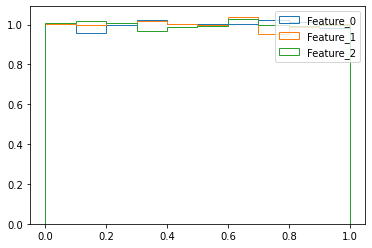

In [10]:
for idx, column in enumerate(df.columns):
    if idx >= len(df.columns) - 2:
        # t and y varaibles
        continue
    plt.hist(df[column], density=True, histtype="step", label=column)
plt.legend()

In [11]:
class UpliftDataset(Dataset): 
    def __init__(
        self,
        df: pd.DataFrame, 
        in_features: int,
        t_idx: Optional[int] = None, 
        y_idx: Optional[int] = None,
    ):
        t_idx = in_features if t_idx is None else t_idx
        y_idx = in_features + 1 if y_idx is None else y_idx

        self.in_features = in_features
        self.t_idx = t_idx
        self.y_idx = y_idx

        self.df = df
        self.X = self.df.iloc[:, 0:in_features]
        self.t = self.df.iloc[:, t_idx]
        self.y = self.df.iloc[:, y_idx]

    def __len__(self): 
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X.iloc[idx, :].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.t.iloc[idx], dtype=torch.float32)
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32)
        return (X, t, y)

In [12]:
num_features = 3

train_set = UpliftDataset(train_df, num_features)
eval_set  = UpliftDataset(eval_df, num_features)

train_dl = DataLoader(train_set, batch_size=128, shuffle=True)
eval_dl  = DataLoader(eval_set, batch_size=128, shuffle=False)

In [13]:
train_set[0]

(tensor([0.7056, 0.1189, 0.5912]), tensor(1.), tensor(0.))

In [14]:
class ComplexModel(nn.Module): 
    def __init__(
        self,
        in_features: int,
    ):
        super().__init__()
        self.expand = nn.Linear(in_features+1, 128)
        self.fc1 = nn.Linear(128, 128) 
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128) 
        self.bn2 = nn.BatchNorm1d(128)
        self.classifier = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):

        x = self.expand(x)
        _x = torch.tanh(self.bn1(self.fc1(x))) 
        x = self.dropout(_x) + x
        _x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout(_x) + x
        x = self.classifier(x)
        return x

In [15]:
train_set[0]
class UpliftWrapper(nn.Module): 
    def __init__(
        self,
        in_features: int,
    ):
        super(UpliftWrapper, self).__init__() 
        self.in_features = in_features 
        self.model = ComplexModel(in_features) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(
        self, 
        x: torch.Tensor, 
        t: torch.Tensor,
    ):
        """Forward function for Uplift model
        Args:
            x: `torch.Tensor`
            t: `torch.Tensor`
        Returns:
            `dict[str, torch.Tensor]`
        """
        # X shape: (B, N)
        if t.ndim == 2:
            t = t.squeeze()
        B = x.size(0)
        L = x.size(1)
        # print(f"input shape: {x.shape}")
        
        # first creating the inputs accordingly
        x_0 = torch.cat([x, torch.zeros([B, 1]).to(x.device)], dim=1) 
        x_1 = torch.cat([x, torch.ones([B, 1]).to(x.device)], dim=1)

        y_0 = self.sigmoid(self.model(x_0)).squeeze()
        y_1 = self.sigmoid(self.model(x_1)).squeeze()
        
        pred = torch.where(t == 1, y_1, y_0)
        return {
            "uplift": y_1 - y_0, "pred": pred,
        }

In [16]:
class DirectUpliftLoss(nn.Module): 
    def __init__(self,
        propensity_score: float = 0.5,
        alpha: Optional[float] = None, 
    ):
        super(DirectUpliftLoss, self).__init__()
        if alpha > 1 or alpha < 0:
            raise ValueError("alpha must be in [0, 1]")
        self.e_x = propensity_score 
        self.alpha = alpha

        self.loss_u = nn.MSELoss() 
        self.loss_y = nn.BCELoss()

    def forward(self, out, t, y):
        z = t * y / self.e_x - (1-t) * y / (1-self.e_x) 
        # variable transformation
        
        loss_uplift = self.loss_u(out["uplift"], z) 
        loss_pred = self.loss_y(out["pred"], y)
        loss = (1-self.alpha) * loss_uplift + self.alpha * loss_pred 
        
        return loss

In [17]:
model = UpliftWrapper(num_features)
criterion = DirectUpliftLoss(0.5, 0.8)

In [18]:
train_set[0][0].unsqueeze(0)

tensor([[0.7056, 0.1189, 0.5912]])

In [19]:
model.eval()
out = model(train_set[0][0].unsqueeze(0), train_set[0][1])
out

{'uplift': tensor(0.0785, grad_fn=<SubBackward0>),
 'pred': tensor(0.5525, grad_fn=<SWhereBackward>)}

In [20]:
X, t, y = next(iter(train_dl))
out = model(X, t)
# print(out)
# print(out["uplift"].shape, out["pred"].shape)

In [21]:
out["pred"].shape, out["uplift"].shape

(torch.Size([128]), torch.Size([128]))

(array([ 3.,  9., 18., 13., 16., 16., 12., 18., 15.,  8.]),
 array([0.07436967, 0.07497504, 0.0755804 , 0.07618576, 0.07679113,
        0.0773965 , 0.07800186, 0.07860723, 0.07921259, 0.07981796,
        0.08042333], dtype=float32),
 <BarContainer object of 10 artists>)

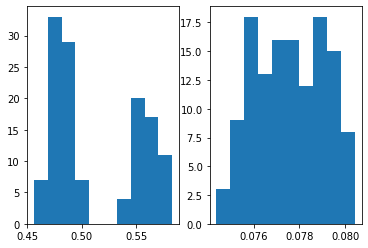

In [22]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(out["pred"].detach().cpu().numpy())
ax[1].hist(out["uplift"].detach().cpu().numpy())

In [23]:
# loss = criterion(out, t, y)
loss = criterion(out, t, y)
loss

tensor(0.6500, grad_fn=<AddBackward0>)

In [24]:
z = t * y / 0.5 - (1-t) * y / (1-0.5)
z

tensor([ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., -2.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0., -2.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

In [26]:
model.cuda()

num_epochs = 20
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}")

    train_answ = []
    train_pred = []

    model.train()
    for X, t, y in tqdm(train_dl):
        optimizer.zero_grad()
        train_answ.extend(y.numpy().tolist())

        X = X.cuda()
        t = t.cuda()
        y = y.cuda()

        out = model(X, t)
        loss = criterion(out, t, y)
        # loss = criterion(out["pred"], y)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        pred = np.where(out["pred"].detach().cpu().numpy() > 0.5, 1, 0)
        train_pred.extend(pred.tolist())

    train_answ = np.array(train_answ)
    train_pred = np.array(train_pred)

    train_accuracies.append(np.sum(train_answ == train_pred)/len(train_answ))
    print(f"train accuracy: {train_accuracies[-1]}, train f1: {f1_score(train_answ, train_pred)}")

    eval_cnt = 0
    eval_corrects = 0

    model.eval()
    with torch.no_grad():

        eval_answ = []
        eval_pred = []

        for X, t, y in tqdm(eval_dl):
            eval_cnt += X.size(0)
            eval_answ.extend(y.numpy().tolist())

            X = X.cuda()
            t = t.cuda()
            y = y.cuda()

            out = model(X, t)
            loss = criterion(out, t, y)
            # loss = criterion(out["pred"], y)
            eval_losses.append(loss.item())

            pred = np.where(out["pred"].detach().cpu().numpy() > 0.5, 1, 0)
            eval_pred.extend(pred.tolist())

    eval_answ = np.array(eval_answ)
    eval_pred = np.array(eval_pred)

    eval_accuracies.append(np.sum(eval_answ == eval_pred)/len(eval_answ))
    print(f"eval accuracy: {eval_accuracies[-1]}, eval f1: {f1_score(eval_answ, eval_pred)}")

    print()


  4%|▍         | 5/125 [00:00<00:02, 43.54it/s]

epoch: 0


 19%|█▉        | 6/32 [00:00<00:00, 57.82it/s]

train accuracy: 0.805125, train f1: 0.47062818336162987


  4%|▍         | 5/125 [00:00<00:02, 46.60it/s]

eval accuracy: 0.85, eval f1: 0.563953488372093

epoch: 1


 19%|█▉        | 6/32 [00:00<00:00, 56.28it/s]

train accuracy: 0.8635, train f1: 0.5939010784678319


  4%|▍         | 5/125 [00:00<00:02, 47.09it/s]

eval accuracy: 0.8825, eval f1: 0.6727019498607243

epoch: 2


 19%|█▉        | 6/32 [00:00<00:00, 55.17it/s]

train accuracy: 0.8731875, train f1: 0.6280476626947755


  4%|▍         | 5/125 [00:00<00:02, 47.28it/s]

eval accuracy: 0.9005, eval f1: 0.729251700680272

epoch: 3


 19%|█▉        | 6/32 [00:00<00:00, 56.74it/s]

train accuracy: 0.8755625, train f1: 0.6384601416379153


  4%|▍         | 5/125 [00:00<00:02, 44.94it/s]

eval accuracy: 0.87175, eval f1: 0.6348754448398577

epoch: 4


 19%|█▉        | 6/32 [00:00<00:00, 58.11it/s]

train accuracy: 0.88075, train f1: 0.6530909090909092


  4%|▍         | 5/125 [00:00<00:02, 47.18it/s]

eval accuracy: 0.88375, eval f1: 0.6851726472579552

epoch: 5


 19%|█▉        | 6/32 [00:00<00:00, 57.61it/s]

train accuracy: 0.8766875, train f1: 0.644824482448245


  4%|▍         | 5/125 [00:00<00:02, 47.70it/s]

eval accuracy: 0.9075, eval f1: 0.7434119278779473

epoch: 6


 19%|█▉        | 6/32 [00:00<00:00, 57.59it/s]

train accuracy: 0.88, train f1: 0.6544276457883369


  4%|▍         | 5/125 [00:00<00:02, 47.92it/s]

eval accuracy: 0.87525, eval f1: 0.6344322344322345

epoch: 7


 19%|█▉        | 6/32 [00:00<00:00, 58.50it/s]

train accuracy: 0.881125, train f1: 0.6616862326574173


  4%|▍         | 5/125 [00:00<00:02, 47.66it/s]

eval accuracy: 0.89075, eval f1: 0.6911660777385159

epoch: 8


 19%|█▉        | 6/32 [00:00<00:00, 57.97it/s]

train accuracy: 0.87925, train f1: 0.6562277580071174


  4%|▍         | 5/125 [00:00<00:02, 48.14it/s]

eval accuracy: 0.882, eval f1: 0.6633380884450785

epoch: 9


 19%|█▉        | 6/32 [00:00<00:00, 58.35it/s]

train accuracy: 0.8816875, train f1: 0.6633469678107771


  4%|▍         | 5/125 [00:00<00:02, 48.45it/s]

eval accuracy: 0.865, eval f1: 0.5774647887323944

epoch: 10


 19%|█▉        | 6/32 [00:00<00:00, 57.86it/s]

train accuracy: 0.879875, train f1: 0.6606638418079096


  4%|▍         | 5/125 [00:00<00:02, 47.16it/s]

eval accuracy: 0.85875, eval f1: 0.5722937168811506

epoch: 11


 19%|█▉        | 6/32 [00:00<00:00, 58.22it/s]

train accuracy: 0.88, train f1: 0.6636299929922915


  4%|▍         | 5/125 [00:00<00:02, 43.97it/s]

eval accuracy: 0.88775, eval f1: 0.7097608274078862

epoch: 12


 19%|█▉        | 6/32 [00:00<00:00, 57.64it/s]

train accuracy: 0.884875, train f1: 0.6743281471004243


  4%|▍         | 5/125 [00:00<00:02, 46.47it/s]

eval accuracy: 0.88575, eval f1: 0.6765746638358104

epoch: 13


 19%|█▉        | 6/32 [00:00<00:00, 57.76it/s]

train accuracy: 0.8808125, train f1: 0.6634903829186519


  4%|▍         | 5/125 [00:00<00:02, 45.68it/s]

eval accuracy: 0.882, eval f1: 0.6544655929721817

epoch: 14


 19%|█▉        | 6/32 [00:00<00:00, 57.90it/s]

train accuracy: 0.8816875, train f1: 0.669344978165939


  4%|▍         | 5/125 [00:00<00:02, 45.15it/s]

eval accuracy: 0.8825, eval f1: 0.6895640686922061

epoch: 15


 19%|█▉        | 6/32 [00:00<00:00, 58.55it/s]

train accuracy: 0.8804375, train f1: 0.6664341761115954


  4%|▍         | 5/125 [00:00<00:02, 47.08it/s]

eval accuracy: 0.86875, eval f1: 0.6067415730337079

epoch: 16


 19%|█▉        | 6/32 [00:00<00:00, 55.35it/s]

train accuracy: 0.88525, train f1: 0.6801393728222996


  4%|▍         | 5/125 [00:00<00:02, 48.23it/s]

eval accuracy: 0.8185, eval f1: 0.3609154929577465

epoch: 17


 19%|█▉        | 6/32 [00:00<00:00, 58.13it/s]

train accuracy: 0.8835625, train f1: 0.6741297883505335


  4%|▍         | 5/125 [00:00<00:02, 44.12it/s]

eval accuracy: 0.8555, eval f1: 0.5946704067321178

epoch: 18


 19%|█▉        | 6/32 [00:00<00:00, 58.19it/s]

train accuracy: 0.8826875, train f1: 0.6769919118912409


  4%|▍         | 5/125 [00:00<00:02, 46.10it/s]

eval accuracy: 0.88875, eval f1: 0.6828225231646472

epoch: 19


 19%|█▉        | 6/32 [00:00<00:00, 56.49it/s]

train accuracy: 0.882125, train f1: 0.6723419041000696


100%|██████████| 32/32 [00:00<00:00, 57.08it/s]

eval accuracy: 0.8785, eval f1: 0.6698369565217391



(array([18.,  3.,  1.,  2.,  3.,  1.,  0.,  1.,  3.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

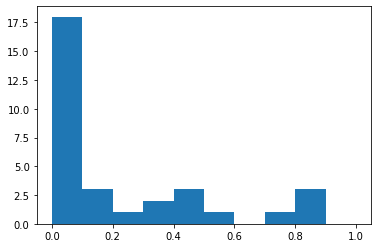

In [27]:
plt.hist(out["pred"].detach().cpu().numpy(), bins=np.arange(0, 1.1, 0.1))

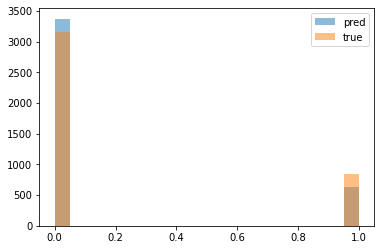

In [28]:
plt.hist(eval_pred, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="pred")
plt.hist(eval_answ, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="true")
plt.legend()
plt.show()

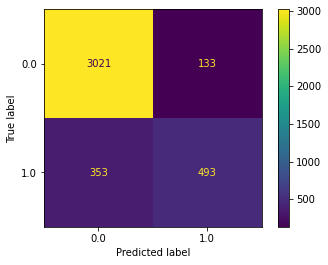

In [29]:
ConfusionMatrixDisplay.from_predictions(eval_answ, eval_pred)

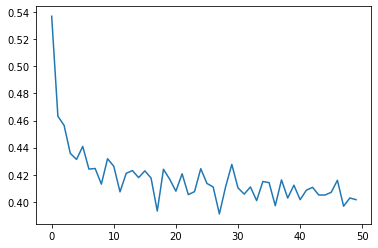

In [30]:
n_size = 50
length = (len(train_losses) // n_size) * n_size
plt.plot(np.array(train_losses[-length:]).reshape(-1, n_size).mean(axis=1))